Éste es el notebook a una postulación que hice, me gustó mucho la solución y como siento que refleja bastante bien mi lógica de desarrollo a la hora de hacer modelos, decidí publicarlo.

La base de datos tratada es una base de datos pública del aeropuerto de Santiago, la cual contiene aterrizajes y despegues del aeropuerto de santiago. El objetivo es **predecir la probabilidad de atraso de los vuelos**.

La estructura de este notebook es la siguiente:

- 1) Diccionario del dataset
- 2) Carga del dataset
- 3) Verificación/validación inicial de calidad de datos
- 4) El primer paso: definición del target y el contexto del negocio
- 5) Análisis univariado
- 6) Generación de variables adicionales
- 7) Análisis bivariado
- 8) Metodología de modelamiento
- 9) Definición de métrica de evaluación y tratamiento de variables cíclicas
- 10) Entrenamiento y evaluación de modelos
- 11) Síntesis, pasos a seguir e ideas finales

### Diccionario del dataset

- `Fecha-I` : Fecha y hora programada del vuelo.
- `Vlo-I` : Número de vuelo programado.
- `Ori-I` : Código de ciudad de origen programado.
- `Des-I` : Código de ciudad de destino programado.
- `Emp-I` : Código aerolínea de vuelo programado.
- `Fecha-O` : Fecha y hora de operación del vuelo.
- `Vlo-O` : Número de vuelo de operación del vuelo.
- `Ori-O` : Código de ciudad de origen de operación
- `Des-O` : Código de ciudad de destino de operación.
- `Emp-O` : Código aerolínea de vuelo operado.
- `DIA` : Día del mes de operación del vuelo.
- `MES` : Número de mes de operación del vuelo.
- `AÑO` : Año de operación del vuelo.
- `DIANOM` : Día de la semana de operación del vuelo.
- `TIPOVUELO` : Tipo de vuelo, I =Internacional, N =Nacional.
- `OPERA` : Nombre de aerolínea que opera.
- `SIGLAORI` : Nombre ciudad origen.
- `SIGLADES` : Nombre ciudad destino.

#### Set-up inicial (paquetes de ML más adelante)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 150)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

#### Estas funciones han sido creadas por mí, son parte de mi "paquete estándar" de análisis


In [2]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

def null_plot(data, title=""):
    
    order = data.isnull().sum().sort_values(ascending=False).index
    
    fig, ax = plt.subplots(figsize=(18,10))
    cmap = sns.mpl_palette("Set2", 2)
    sns.heatmap(data=data.isnull().reindex(order, axis=1), cmap=cmap, cbar=False, yticklabels=len(data)//30)
    
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.suptitle(t=title, x=0.14, y=0.98, fontsize = 20, fontweight="semibold")
    legend_handles = [Patch(color=cmap[True], label='Missing Value'),
                      Patch(color=cmap[False], label='Non Missing Value')] 
    plt.legend(handles=legend_handles, ncol=2, bbox_to_anchor=[0.86, 1.02], loc='lower center', fontsize=15, handlelength=.8)
    plt.tight_layout()
    plt.savefig("figura", format='png')
    plt.show()
    
    
def null_plot_ordered(df, col):
    data = df.copy()
    data.index = data[col]
    return(null_plot(data.sort_index(ascending=False)))


def categ_plots_grouped(df_grouped, column_to_plot):
    tabla = df_grouped[column_to_plot].value_counts().unstack()
    tabla.loc["Total"] = df_grouped[column_to_plot].value_counts().unstack().sum().tolist()
    display(tabla)

    tabla2 = df_grouped[column_to_plot].value_counts().unstack().apply(lambda x: x/sum(x))
    display(tabla2)
    
    plt.figure(figsize=(15,3))
    tabla2.loc[1].plot(kind="bar")
    plt.title(column_to_plot)
    
    display(tabla2.loc[1,:].div(tabla2.loc[1,:].min())-1)
    
    plt.show()
    
def stats_describe(data):
    stats = data.describe()
    stats.loc["var"] = data.var().tolist()
    stats.loc["skewness"] = data.skew().tolist()
    stats.loc["kurtosis"] = data.kurtosis().tolist()
    stats.loc["count_nan"] = data.isnull().sum()
    stats.loc["pct_nan"] = (data.isnull().sum()/len(data))
    stats.loc["dtype"] = data.dtypes
    return stats

#### Cargamos el dataset

In [3]:
df = pd.read_csv("input/dataset_SCL.csv")
display(df.shape)
df.head(3)

C:\Users\ecyf3288\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(68206, 18)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami


# Verificación/validación inicial de calidad de datos

#### Verificamos `Fecha_I` y `Fecha-O`, por el `DtypeWarning` anterior, que tengan 19 carácteres (`YYYY-MM-DD HH:MM:SS` = 19 carácteres). En caso de que tengan algo diferente habría que evaluar porqué

In [4]:
df["Fecha-I"].str.len().value_counts()

19    68206
Name: Fecha-I, dtype: int64

In [5]:
df["Fecha-O"].str.len().value_counts()

19    68206
Name: Fecha-O, dtype: int64

#### Cambiamos a formatos correspondientes

In [6]:
df["Fecha-I"] = pd.to_datetime(df["Fecha-I"])
df["Fecha-O"] = pd.to_datetime(df["Fecha-O"])

#### Evaluamos valores únicos por columna: si hacen consistencia con su respectivo dtypes

In [7]:
for i in df.columns:
    print(df[i].value_counts(dropna=False), "\n")

2017-03-19 18:00:00    6
2017-03-26 18:00:00    6
2017-07-28 13:30:00    6
2017-04-02 18:00:00    5
2017-08-05 08:00:00    5
                      ..
2017-11-26 15:35:00    1
2017-04-24 05:00:00    1
2017-08-31 07:10:00    1
2017-01-26 20:35:00    1
2017-07-10 10:05:00    1
Name: Fecha-I, Length: 53252, dtype: int64 

174     686
11      645
116     608
150     557
162     553
       ... 
1800      1
1034      1
1151      1
1149      1
356       1
Name: Vlo-I, Length: 750, dtype: int64 

SCEL    68206
Name: Ori-I, dtype: int64 

SCFA    5787
SPJC    5270
SCCF    5145
SCTE    4357
SCIE    3995
SCDA    3747
SBGR    3570
SAEZ    3240
SABE    3094
SCQP    2583
SCAR    2436
SCSE    2410
SCCI    2105
MPTO    1850
SCAT    1780
SAME    1625
SKBO    1604
SBGL    1434
SUMU    1066
SACO    1023
KMIA    1015
LEMD     894
SCBA     843
SCVD     753
MMMX     700
SCIP     452
SEGU     423
KJFK     383
NZAA     361
LFPG     359
KATL     358
KDFW     357
KIAH     335
CYYZ     283
LIRF     259
SCJO     2

In [8]:
df.dtypes

Fecha-I      datetime64[ns]
Vlo-I                object
Ori-I                object
Des-I                object
Emp-I                object
Fecha-O      datetime64[ns]
Vlo-O                object
Ori-O                object
Des-O                object
Emp-O                object
DIA                   int64
MES                   int64
AÑO                   int64
DIANOM               object
TIPOVUELO            object
OPERA                object
SIGLAORI             object
SIGLADES             object
dtype: object

#### Evaluamos missing values

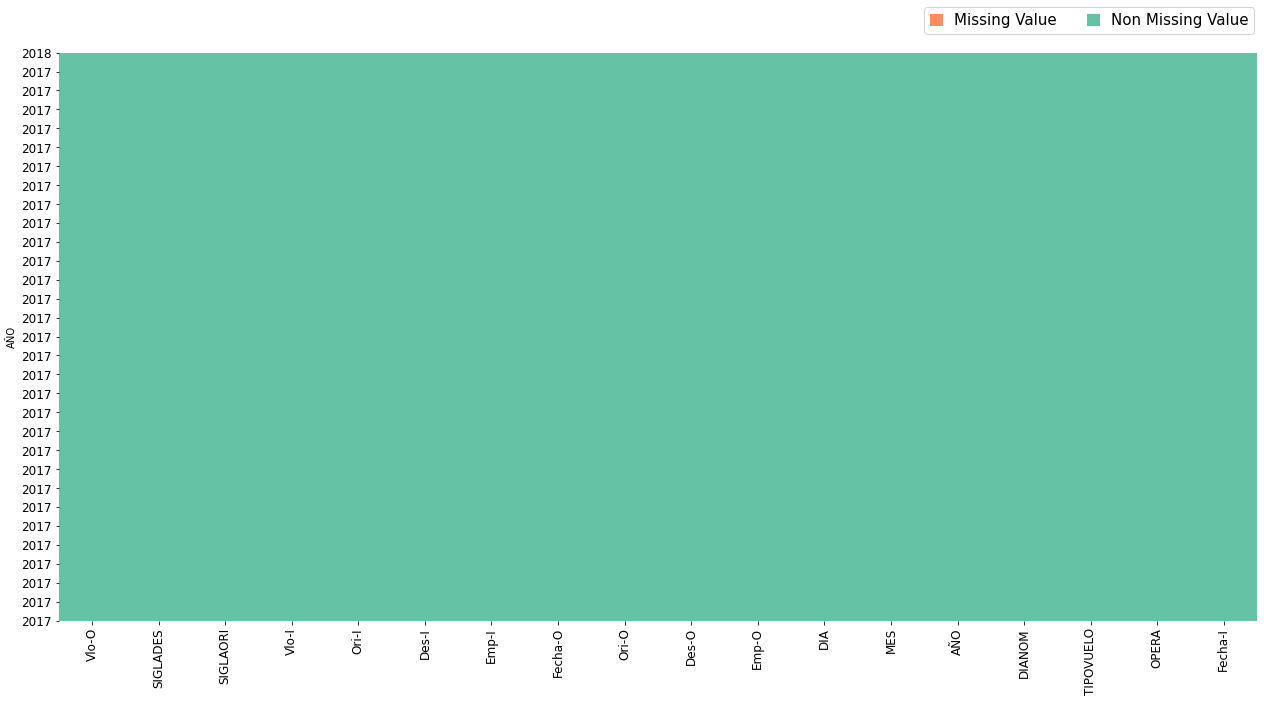

In [9]:
data = df.copy()
null_plot_ordered(df, "AÑO")

#### Al ver que no existen missing values, podemos decir que es literalmente hermoso este dataset. 

Además que en la evaluación anterior de valores únicos por columna no se encontraron missing values como string. Por ejemplo, hay veces que si bien el missing no es un `NaN` o `NaT`, se muestra como distintos strings que difieren de la data. Casos comunes son `?`, `,"`, ` `, e incluso `NaN` como texto (`"NaN"`).

# El primer paso

El primer paso antes de cualquier análisis de variables, de base de datos, o modelamiento, es tener muy en claro la definición de la variable a predecir, y lo que refleja cada observación del dataset. Por lo tanto:

Sabemos que cada observación del dataset es un vuelo que aterrizó o despegó en el aeropuerto de Santiago, donde dicho vuelo tiene un día y hora planificada y un día y hora operado, pudiendo estos tiempos ser diferentes.

Como buscamos predecir el atraso de los vuelos, podemos **definir el atraso como la diferencia entre el tiempo planificado y el tiempo operado**. Sin embargo, esto nos llevaría a la pregunta ¿cuánto tiempo de atraso del vuelo se puede considerar que es un vuelo atrasado?. Si nos ponemos estrictos, cualquier diferencia entre lo planificado y lo operado debería ser considerado un atraso. Sin embargo, **¿hace esto sentido al negocio?** Un segundo de atraso, probablemente no lo hará, un minuto tampoco. ¿Lo serán 10 minutos de atraso del vuelo? ¿30 minutos? ¿Una hora?. En consecuencia, la pregunta es: **¿cómo definimos el *threshold* para decidir cuándo un vuelo se atrasó y cuándo no, de tal forma que este *threshold* vaya en línea con el negocio?**

### El negocio

Se entiende que **las aerolíneas buscan minimizar los atrasos de sus vuelos** porque (supuesto) existen multas. Por experiencia propia, sé que si un vuelo se atrasa más de tres horas la aerolínea debe incurrir en indemnizaciones a los usuarios de vuelo, implicando un aumento de costos para la aerolínea. Por otra parte, (supuesto) probablemente el aeropuerto de Santiago aplique multas a las aerolíneas que utilicen las puertas de desembarque/embarque por más del tiempo planificado, en la página del aeropuerto de Santiago, en la sección de [tarifas corporativas](https://www.nuevopudahuel.cl/tarifas-corporativas]) se pueden ver los costos estándares que el aeropuerto aplica a las aerolíneas por el uso de embarque y desembarque. Probablemente si la aerolínea tiene muchos aviones y haga una alta utlización del aeropuerto tenga un contrato específico a tarifas rebajadas por el alto uso del aeropuerto. Asumiremos que la aerolínea comienza a recibe multas si los atrasos son superiores a 15 minutos.

Por simplicidad y con el fin de crear un modelo de clasificación, definiremos un atraso significativo si la diferencia de tiempo entre el vuelo planificado y el vuelo operado supera los 15 minutos.

**Consideraciones de esta definición**: Si un vuelo se atrasa 20 minutos y otro se atrasa 4 horas, los costos para la aerolínea son diferentes dado que las multas para el vuelo atrasado en 4 horas son mucho mayores al que se atrasó 20 minutos. Sin embargo, esta diferencia no está siendo considerada bajo la definición actual, sino que se asume que ambos costos son iguales. Decidí hacer esto por simplicidad y no alargarme más, pero en estricto rigor habría que evaluar si es significativo ignorar esta diferencia en costos, si es signiticativa la diferencia habría que integrar esa diferencia en la definición de la variable dependiente, si no resulta significativa la diferencia podemos dejar la definición simple que acabamos de hacer.

Por lo tanto, definiremos un vuelo atrasado si su tiempo de diferencia entre lo planificado y operado es mayor a 15 minutos.

### Chequeamos la existencia de segundos

In [10]:
df["Fecha-I"].dt.second.value_counts()

0    68206
Name: Fecha-I, dtype: int64

In [11]:
df["Fecha-O"].dt.second.value_counts()

0    68206
Name: Fecha-O, dtype: int64

Con esto sabemos que podemos ignorar los segundos completamente y los atrasos de vuelos serán calculados solamente por la diferencia minutos completos.

#### Creación de variable `dif_min`: Diferencia entre el vuelo planificado y operado

In [12]:
df["dif_min"] = (df["Fecha-O"] - df["Fecha-I"])/np.timedelta64(1, "m")

In [13]:
# CHECK VISUAL
df[["Fecha-O", "Fecha-I","dif_min"]].head()

,Fecha-O,Fecha-I,dif_min
0,2017-01-01 23:33:00,2017-01-01 23:30:00,3.0000
1,2017-01-02 23:39:00,2017-01-02 23:30:00,9.0000
2,2017-01-03 23:39:00,2017-01-03 23:30:00,9.0000
3,2017-01-04 23:33:00,2017-01-04 23:30:00,3.0000
4,2017-01-05 23:28:00,2017-01-05 23:30:00,-2.0000


#### Creación de variable `atraso_15`: Si es que el vuelo se atrasó por más de 15 minutos

In [14]:
df["atraso_15"] = np.where(df["dif_min"] > 15, 1, 0)

## Análisis univariado

Consideraremos las cantidades de valores únicos y su dtypes de cada variable para decidir qué gráfico utilizar.

In [15]:
for i in df.columns:
    print(i,":", df[i].drop_duplicates().shape[0], ":", df[i].dtypes)

Fecha-I : 53252 : datetime64[ns]
Vlo-I : 750 : object
Ori-I : 1 : object
Des-I : 64 : object
Emp-I : 30 : object
Fecha-O : 62774 : datetime64[ns]
Vlo-O : 867 : object
Ori-O : 1 : object
Des-O : 63 : object
Emp-O : 32 : object
DIA : 31 : int64
MES : 12 : int64
AÑO : 2 : int64
DIANOM : 7 : object
TIPOVUELO : 2 : object
OPERA : 23 : object
SIGLAORI : 1 : object
SIGLADES : 62 : object
dif_min : 176 : float64
atraso_15 : 2 : int32


#### 1.a Evaluaremos primero las variables que tienen la cantidad de valores únicos = 1

In [16]:
for i in df.columns:
    if df[i].drop_duplicates().shape[0] == 1:
        print(df[i].value_counts().div(df.shape[0]), "\n")

SCEL   1.0000
Name: Ori-I, dtype: float64 

SCEL   1.0000
Name: Ori-O, dtype: float64 

Santiago   1.0000
Name: SIGLAORI, dtype: float64 



Vemos que todos los valores de estas variables son los mismos, por lo que todas las observaciones del dataset corresponden a vuelos con origen programado y origen operativo a Santiago. Por lo tanto, podemos concluir que todos los vuelos de este dataset tienen como origen la ciudad de Santiago. Eliminar variables con varianza = 0 ayuda a disminuir el tiempo de procesamiento de análisis posteriores, y como estas variables constantes no nos proveerán ninguna información a la hora de modelar, las eliminaremos:

In [17]:
df.drop(["Ori-I", "Ori-O", "SIGLAORI"], axis=1, inplace=True)

#### 1.b Una misma ciudad debiese tener un mismo código de ciudad, tanto como programado y operativo. Por tanto, evaluaremos la consistencia de los datos de `SIGLADES`, `Des-I` y `Des-O`

In [18]:
cols_destino = ["Des-I", "Des-O", "SIGLADES"]

In [19]:
df.groupby(cols_destino).size()

Des-I  Des-O  SIGLADES        
CYYZ   CYYZ   Toronto              283
EGLL   EGLL   Londres              205
EGYP   EGYP   Puerto Stanley         1
KATL   KATL   Atlanta              358
KDFW   KDFW   Dallas               357
KIAH   KIAD   Washington             1
       KIAH   Houston              334
KJFK   KJFK   Nueva York           382
       KMIA   Miami                  1
KLAX   KLAX   Los Angeles          155
KMCO   KMCO   Orlando               34
KMIA   KMIA   Miami               1015
LEMD   LEMD   Madrid               894
LFPG   LFPG   Paris                359
LIRF   LIRF   Roma                 259
MDPC   MDPC   Punta Cana            54
MMMX   MMMX   Ciudad de Mexico     700
MMUN   MMUN   Cancun                63
MPTO   MPTO   Ciudad de Panama    1850
NZAA   NZAA   Auckland N.Z.        361
SAAR   SAAR   Rosario              136
SABE   SABE   Buenos Aires        3090
       SAEZ   Buenos Aires           4
SACO   SACO   Cordoba             1023
SAEZ   SABE   Buenos Aires       

Vemos que para un mismo `SIGLADES` pueden existir distintos `Des-I` y `Des-O`. Al mirar sólo estas diferencias:

In [20]:
mask = df["Des-I"] != df["Des-O"]
df[mask].groupby(cols_destino).size()

Des-I  Des-O  SIGLADES        
KIAH   KIAD   Washington          1
KJFK   KMIA   Miami               1
SABE   SAEZ   Buenos Aires        4
SAEZ   SABE   Buenos Aires        3
SARI   SBFI   Cataratas Iguacu    1
SBGR   SBGL   Rio de Janeiro      1
SCBA   SCTE   Puerto Montt        4
SCCI   SCTE   Puerto Montt        1
SCFA   SCCF   Calama              1
SCIE   SCQP   Temuco              1
       SCTE   Puerto Montt        1
SCTE   SCCI   Punta Arenas        1
       SCQP   Temuco              5
SEGU   SABE   Buenos Aires        1
SEQU   SEQM   Quito               1
YSSY   YMML   Melbourne           1
dtype: int64

¿Es posible que para dos valores distintos de `Des-I` de cumpla la condición `Des-I == Des-O` y que tenga `SIGLADES` diferentes?

In [21]:
mask = df["Des-I"] == df["Des-O"]
data = df[mask].groupby(cols_destino).size().rename("count").reset_index()
data[data["SIGLADES"].duplicated(keep=False)]

,Des-I,Des-O,SIGLADES,count
19,SABE,SABE,Buenos Aires,3090
21,SAEZ,SAEZ,Buenos Aires,3237


De la tabla anterior vemos que sí es posible, la ciudad de Buenos Aires es la única que cumple con las condiciones.

Por último, verificaremos que Santiago está como destino:

In [22]:
mask = df["SIGLADES"].str.upper().str.contains("SAN") # utilizamos UPPER para evitar diferencias de minusculas y mayusculas
df[mask].groupby(cols_destino).size().rename("count").reset_index()

,Des-I,Des-O,SIGLADES,count
0,SANU,SANU,"San Juan, Arg.",35
1,SLVR,SLVR,Santa Cruz,120


De lo anterior vemos que SCL no está como ciudad de destino

#### 1.c Similar a 1.b, evaluaremos la consistencia de datos entre `Emp-I`, `Emp-O`, `OPERA`

In [23]:
cols_operador = ["Emp-I", "Emp-O", "OPERA"]

In [24]:
df.groupby(cols_operador).size()

Emp-I  Emp-O  OPERA                   
AAL    AAL    American Airlines             757
ACA    ACA    Air Canada                    565
AFR    AFR    Air France                    358
AMX    AMX    Aeromexico                    351
ARG    ARG    Aerolineas Argentinas        1944
       AUT    Aerolineas Argentinas           5
AUT    ARG    Austral                         2
       AUT    Austral                        72
AVA    AVA    Avianca                       885
       LRC    Avianca                       265
       TPU    Avianca                         2
AZA    AZA    Alitalia                      259
BAW    BAW    British Airways               205
CMP    CMP    Copa Air                     1850
DAL    DAL    Delta Air                     358
DSM    DSM    Grupo LATAM                     2
GLO    GLO    Gol Trans                     806
IBE    IBE    Iberia                        362
JAT    JAT    JetSmart SPA                 1095
JMR    JMR    Latin American Wings          100
K

In [25]:
mask = df["Emp-I"] == df["Emp-O"]
df[mask].groupby(cols_operador).size().sort_index(level=0)

Emp-I  Emp-O  OPERA                   
AAL    AAL    American Airlines             757
ACA    ACA    Air Canada                    565
AFR    AFR    Air France                    358
AMX    AMX    Aeromexico                    351
ARG    ARG    Aerolineas Argentinas        1944
AUT    AUT    Austral                        72
AVA    AVA    Avianca                       885
AZA    AZA    Alitalia                      259
BAW    BAW    British Airways               205
CMP    CMP    Copa Air                     1850
DAL    DAL    Delta Air                     358
DSM    DSM    Grupo LATAM                     2
GLO    GLO    Gol Trans                     806
IBE    IBE    Iberia                        362
JAT    JAT    JetSmart SPA                 1095
JMR    JMR    Latin American Wings          100
KLM    KLM    K.L.M.                        251
LAN    LAN    Grupo LATAM                 20988
LAP    LAP    Grupo LATAM                   216
LNE    LNE    Grupo LATAM                     1
L

In [26]:
mask = df["Emp-I"] != df["Emp-O"]
df[mask].groupby(cols_operador).size().sort_index(level=2)

Emp-I  Emp-O  OPERA                
ARG    AUT    Aerolineas Argentinas        5
AUT    ARG    Austral                      2
AVA    LRC    Avianca                    265
       TPU    Avianca                      2
LAN    DSM    Grupo LATAM                491
       LNE    Grupo LATAM                373
       LPE    Grupo LATAM               1210
       LXP    Grupo LATAM              14549
TAM    LAP    Grupo LATAM                  3
LAW    48O    Latin American Wings        10
       56R    Latin American Wings        17
       JMR    Latin American Wings      1547
QFU    QFA    Qantas Airways             195
dtype: int64

De lo anterior, podemos ver que la relación entre las tres variables no es 1:1:1, pero sí es 1:1 para `Emp-I` y `OPERA`.

In [27]:
for i in df.columns:
    print(i,":", df[i].drop_duplicates().shape[0], ":", df[i].dtypes)

Fecha-I : 53252 : datetime64[ns]
Vlo-I : 750 : object
Des-I : 64 : object
Emp-I : 30 : object
Fecha-O : 62774 : datetime64[ns]
Vlo-O : 867 : object
Des-O : 63 : object
Emp-O : 32 : object
DIA : 31 : int64
MES : 12 : int64
AÑO : 2 : int64
DIANOM : 7 : object
TIPOVUELO : 2 : object
OPERA : 23 : object
SIGLADES : 62 : object
dif_min : 176 : float64
atraso_15 : 2 : int32


#### Gráficos univariados

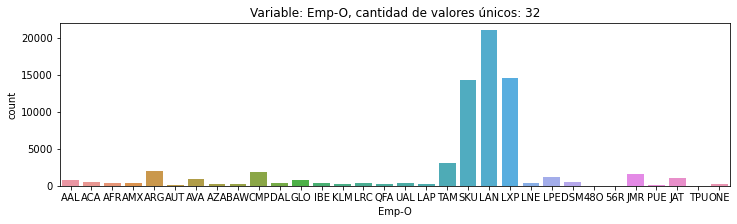

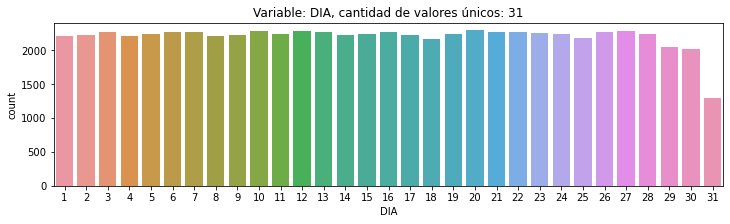

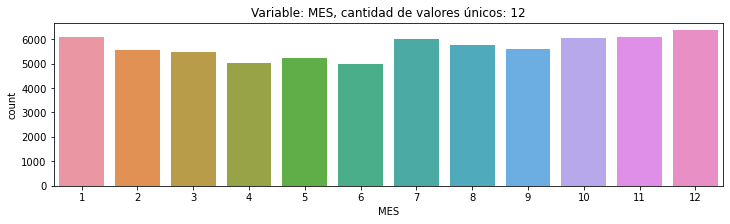

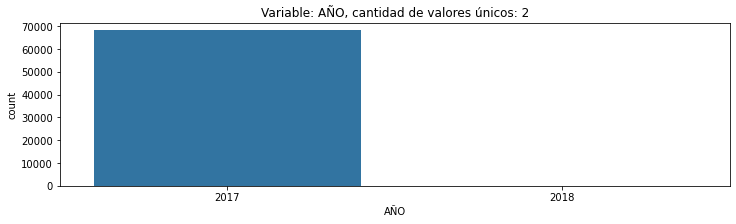

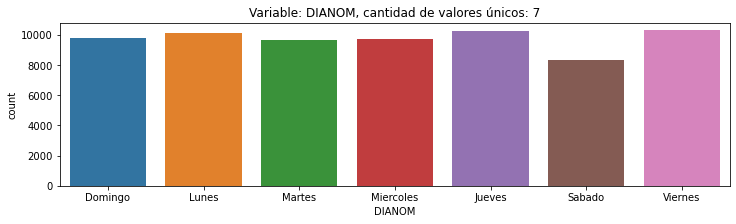

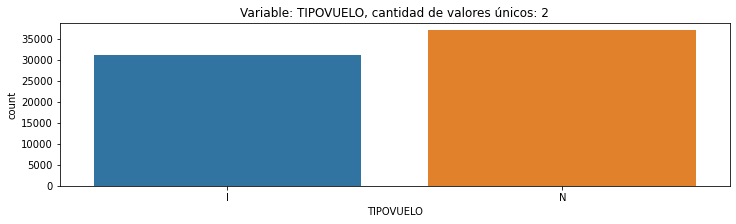

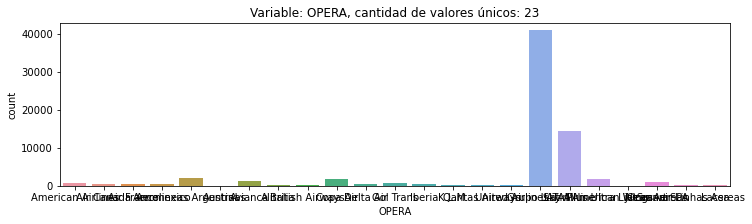

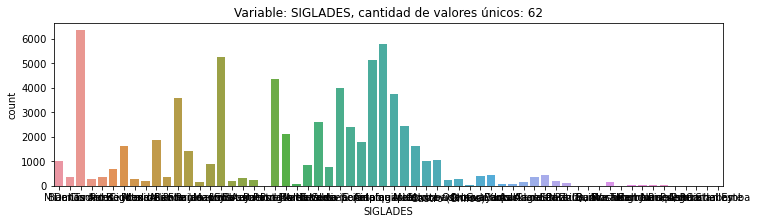

In [28]:
cols = df.loc[:,"Emp-O":"SIGLADES"].columns

for i in cols:
    plt.figure(figsize=(12,3))
    sns.countplot(x=i, data=df)
    n_cat = df[i].drop_duplicates().shape[0]
    plt.title(f'''Variable: {i}, cantidad de valores únicos: {n_cat}''')
    plt.show()
    print("\n")

#### Conclusiones pregunta 1 y síntesis de gráficos univariados

- `Emp-O`: La mayoría de las observaciones se concentran en unas pocas empresas operadoras.
- `DIA`: Las observaciones distribuyen relativamente uniforme, dejando el día 31 con la menor cantidad de observaciones (probablemente porque hay menos días 31 en el año).
- `MES`: Se puede apreciar una mayor cantidad de vuelos en temporadas de vacaciones (Meses 1, 7, 12).
- `AÑO`: Todas las variables son del año 2017, esta variable presenta dos registros del año 2018 porque fueron planificadas en cerca de la medianoche de diciembre 2017 y operadas en la madrugada del 1 de Enero del 2018.
- `DIANOM`: Distribuye uniforme con la exepción del día sábado donde se aprecia una menor cantidad de vuelos, probablemente sea porque la mayoría (supuesto mío) de las personas viajan de viernes a domingo (un fin de semana completo).
- `TIPOVUELO`: Hubieron más vuelos nacionales que internacionales en el año 2017.
- `OPERA`: Los vuelos se concentran en unos pocos operadores.
- `SIGLADES`: Los destinos tienen bastante diferentes cantidades de vuelo en el año 2017.

Me llama la atención la concentración de vuelos en pocos operadores, así como la varianza entre los diferentes destinos.

- Sabemos que el problema define las observaciones del dataset como "*un vuelo que aterrizó o despegó de SCL*". Por 1.a y 1.b sabemos que todas las observaciones corresponden a vuelos que despegaron en Santiago y que el dataset no contiene ninguna observación de un vuelo que aterrizó en Santiago.
- Para un mismo nombre de ciudad de destino `SIGLADES` existen diferencias entre los códigos de destino programado `Des-I` y los códigos de destino operativo `Des-O`. Esto podría deberse a diversos factores que desconocemos, e incluso podría ayudarnos a predecir los atrasos de los vuelos, dado que podría deberse a cambios imprevistos en la planificación haciendo más dificultoso el vuelo planificado cumpla con los tiempos planificados.

### Análisis univariado de la variable dependiente

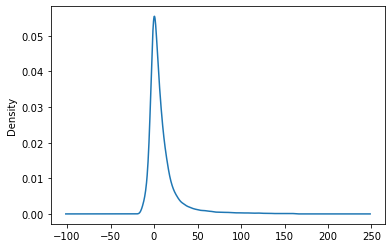

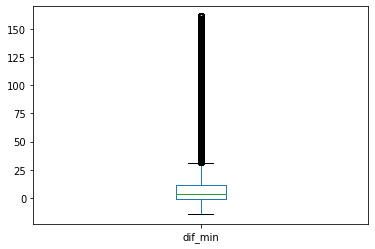

In [29]:
df["dif_min"].plot(kind="kde")
plt.show()
df["dif_min"].plot(kind="box")
plt.show()

Interesante ver que existe una gran cantidad de outliers en la variable `dif_min`. Esto muestra que puede haber un gap entre el modelo y la realidad al definir como 15 minutos el threshold para clasificar los vuelos como atrasados y no atrasados. ¿Porqué un gap? Porque que por un vuelo que se atrase excesivamente (ejemplo: 4 horas vs 20 minutos), la aerolínea recibe multas tanto por el aeropuerto como tener que indemnizar a los usuarios que viajan, implicando que un atraso mayor a 150 minutos sea mucho más caro que un atraso de 15 minutos, y al definir el threshold de 15 minutos estamos tomando ambos atrasos con un costo equivalente cuando en la práctica en el negocio probablemente no es así (propuesta/idea al final). 

Los outliers que se pueden ver en este gráfico están definidos como:

$outlier : \mathcal{I} (Q_3 + 1.5*IQR < x)$ donde:

- $I$: *indicator function*
- $Q_3$: tercer cuartil
- $IQR$: rango intercuartil
- $x$: dato de la columna `dif_min`

La función anterior se puede interpretar: Si $x$ es mayor al intercuartil multiplicado por 1.5 más el valor del tercer cuartil, entonces $x$ es un outlier.

### Generación de variables adicionales

#### Creación de variable `temporada_alta`

In [30]:
# Creamos variables auxiliar Mes-Dia
mes = np.where(df["Fecha-I"].dt.month < 10, "0" + df["Fecha-I"].dt.month.astype(str), df["Fecha-I"].dt.month.astype(str))
dia = np.where(df["Fecha-I"].dt.day < 10, "0" + df["Fecha-I"].dt.day.astype(str), df["Fecha-I"].dt.day.astype(str))

df["Mes-Dia"] = mes + dia

In [31]:
# CHECK VISUAL
df[["Mes-Dia", "Fecha-I"]].drop_duplicates()

,Mes-Dia,Fecha-I
0,0101,2017-01-01 23:30:00
1,0102,2017-01-02 23:30:00
2,0103,2017-01-03 23:30:00
3,0104,2017-01-04 23:30:00
4,0105,2017-01-05 23:30:00
...,...,...
68200,1220,2017-12-20 14:55:00
68201,1222,2017-12-22 14:55:00
68202,1225,2017-12-25 14:55:00
68204,1229,2017-12-29 14:55:00


In [32]:
# mask para crear variable temporada_alta
mask = (df["Mes-Dia"] >= "1215") | (df["Mes-Dia"] <= "0303")
mask |= (df["Mes-Dia"] >= "0715") & (df["Mes-Dia"] <= "0731")
mask |= (df["Mes-Dia"] >= "0911") & (df["Mes-Dia"] <= "0930")

# creación de variable temporada_alta
df["temporada_alta"] = np.where(mask, 1, 0)

In [33]:
# CHECK VISUAL
df.loc[mask, ["Mes-Dia", "temporada_alta"]].drop_duplicates()

,Mes-Dia,temporada_alta
0,0101,1
1,0102,1
2,0103,1
3,0104,1
4,0105,1
5,0106,1
6,0107,1
7,0108,1
8,0109,1
9,0111,1


#### Creación de variable `periodo_dia`

In [34]:
# dataframe auxiliar
data = df.copy()
data.index = data["Fecha-I"]

# creamos los intervalos de tiempos
data["manana"] = data.index.isin(data.between_time('5:00', '11:59').index)
data["tarde"] = data.index.isin(data.between_time('12:00', '18:59').index)
data["noche"] = data.index.isin(data.between_time('19:00', '4:59').index)

In [35]:
# CHECK
data[["manana", "tarde", "noche"]].sum(axis=1).value_counts()

1    68206
dtype: int64

In [36]:
# proceso para juntar las variables en una sola
data["manana"] = data["manana"].replace({True:1, 0:0})
data["tarde"] = data["tarde"].replace({True:2, 0:0})
data["noche"] = data["noche"].replace({True:3, 0:0})

In [37]:
# creamos la variable correspondiente en dataframe auxiliar
data["periodo_dia"] = data[["manana", "tarde", "noche"]].sum(axis=1).replace({1:"Mañana", 2:"Tarde", 3:"Noche"})

In [38]:
df["periodo_dia"] = data["periodo_dia"].values # como no cambiamos ningún orden en 'data', no hay problema en realizar esta creación

### Análisis bivariado: ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo? ¿Qué variables esperarías que más influyeran en predecir atrasos?

Para este análisis crearemos dos columnas adicionales:
- `If_Des_diff`: 1 si los códigos `Des-I` y `Des-O` son diferentes, 0 otro caso
- `If_Emp_diff`: 1 si los códigos `Emp-I` y `Emp-O` son diferentes, 0 otro caso

La diferencia de códigos de lo planificado y lo operativo podría darnos información al respecto, dado que el cambio de código implica un cambio en lo inicialmente planificado, tanto como el aeropuerto de destino y el código de la aerolínea.

In [39]:
df["If_Des_diff"] = df["Des-I"] != df["Des-O"]
df["If_Emp_diff"] = df["Emp-I"] != df["Emp-O"]

In [40]:
cols_analysis = ["SIGLADES", "OPERA", "MES", "DIANOM", "temporada_alta", "TIPOVUELO", "dif_min", "atraso_15", 'If_Des_diff', 'If_Emp_diff']

In [41]:
df.columns

Index(['Fecha-I', 'Vlo-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O', 'Des-O',
       'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO', 'OPERA',
       'SIGLADES', 'dif_min', 'atraso_15', 'Mes-Dia', 'temporada_alta',
       'periodo_dia', 'If_Des_diff', 'If_Emp_diff'],
      dtype='object')

In [42]:
df[cols_analysis].dtypes

SIGLADES           object
OPERA              object
MES                 int64
DIANOM             object
temporada_alta      int32
TIPOVUELO          object
dif_min           float64
atraso_15           int32
If_Des_diff          bool
If_Emp_diff          bool
dtype: object

#### Explicación de función `categ_plots_grouped()` a utilizar

`categ_plots_grouped()` es una función que creé y que me gusta utilizar bastante (la definición de la función está al principio de este notebook) dado que permite visualizar cómo se comporta la variable independiente categórica con la variable dependiente binaria en relación al total de observaciones de cada categoría de la variable independiente. 

Por ejemplo, si tenemos **10 clientes: 3 mujeres y 7 hombres**, y compran vuelos 3 hombres y 2 mujeres, al hacer un simple countplot vemos que más hombres que mujeres compraron (3 hombres vs 2 mujeres) pudiendo llevar erróneamente a la conclusión que más hombres que mujeres compran (dado que estaríamos ignorando la distribución de la variable dependiente por cada categoría de la variable independiente). Y a falta de un gráfico que me solucionara este problema, nació `categ_plots_grouped()`.

Lo que hace este gráfico, es retornar lo siguiente: 

- **(1) Tabla 1**: Conteo agrupado por la variable dependiente por cada categoría de la variable independiente y su total respectivo.
- **(2) Tabla 2**: Ídem, pero el porcentaje en relación a cada categoría (los 1 y 0 de cada categoría suman 100%)
- **(3) Series 1**: Son los porcentajes de la clase positiva de la tabla 2, divididos por el porcentaje menor de la misma tabla. Siguiendo el ejemplo anterior de los 10 clientes, sabemos que 66,7% (2/3) de las mujeres compran y 43% (3/7) de los hombres compran, esta serie calcula el 66,7% / 43% = 1,55. Esto quiere decir que las mujeres (el numerador) tienden a comprar 55% (1.55 -1) más que los hombres. Esta serie suele ser bastante útil con variables binarias, con variables con categorías mayor a 3 se pierde un poco el sentido de la comparación dado que depende de la categoría que menos compró.
- **(4) Gráfico 1**: Son los porcentajes 66,7% y 43% del ejemplo anterior. Visualmente se interpreta como "un 66,7% de las mujeres tienden a comprar vs un 43% de los hombres)

SIGLADES,Antofagasta,Arica,Asuncion,Atlanta,Auckland N.Z.,Balmaceda,Bariloche,Bogota,Buenos Aires,Calama,Cancun,Castro (Chiloe),Cataratas Iguacu,Ciudad de Mexico,Ciudad de Panama,Cochabamba,Concepcion,Copiapo,Cordoba,"Curitiba, Bra.",Dallas,Florianapolis,Guayaquil,Houston,Iquique,Isla de Pascua,La Paz,La Serena,Lima,Londres,Los Angeles,Madrid,Melbourne,Mendoza,Miami,Montevideo,Neuquen,Nueva York,Orlando,Osorno,Paris,"Pisco, Peru",Puerto Montt,Puerto Natales,Puerto Stanley,Punta Arenas,Punta Cana,Punta del Este,Quito,Rio de Janeiro,Roma,Rosario,"San Juan, Arg.",Santa Cruz,Sao Paulo,Sydney,Temuco,Toronto,Tucuman,Ushuia,Valdivia,Washington
atraso_15,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4939.0000,2106.0000,166.0000,337.0000,226.0000,716.0000,1.0000,1189.0000,4715.0000,4517.0000,51.0000,217.0000,2.0000,634.0000,1734.0000,nan,3370.0000,1538.0000,715.0000,3.0000,332.0000,132.0000,340.0000,317.0000,3107.0000,363.0000,177.0000,2020.0000,4056.0000,176.0000,116.0000,724.0000,18.0000,1182.0000,822.0000,846.0000,33.0000,300.0000,25.0000,209.0000,328.0000,1.0000,3623.0000,72.0000,nan,1781.0000,36.0000,5.0000,nan,1030.0000,230.0000,82.0000,27.0000,90.0000,2688.0000,81.0000,2186.0000,194.0000,28.0000,2.0000,636.0000,1.0000
1,847.0000,330.0000,66.0000,21.0000,135.0000,123.0000,1.0000,415.0000,1620.0000,629.0000,12.0000,18.0000,nan,66.0000,116.0000,1.0000,623.0000,242.0000,308.0000,nan,25.0000,30.0000,82.0000,17.0000,640.0000,89.0000,32.0000,390.0000,1214.0000,29.0000,39.0000,170.0000,21.0000,443.0000,194.0000,220.0000,4.0000,82.0000,9.0000,50.0000,31.0000,nan,734.0000,7.0000,1.0000,324.0000,18.0000,1.0000,2.0000,405.0000,29.0000,54.0000,8.0000,30.0000,881.0000,113.0000,403.0000,89.0000,10.0000,4.0000,117.0000,nan
Total,5786.0000,2436.0000,232.0000,358.0000,361.0000,839.0000,2.0000,1604.0000,6335.0000,5146.0000,63.0000,235.0000,2.0000,700.0000,1850.0000,1.0000,3993.0000,1780.0000,1023.0000,3.0000,357.0000,162.0000,422.0000,334.0000,3747.0000,452.0000,209.0000,2410.0000,5270.0000,205.0000,155.0000,894.0000,39.0000,1625.0000,1016.0000,1066.0000,37.0000,382.0000,34.0000,259.0000,359.0000,1.0000,4357.0000,79.0000,1.0000,2105.0000,54.0000,6.0000,2.0000,1435.0000,259.0000,136.0000,35.0000,120.0000,3569.0000,194.0000,2589.0000,283.0000,38.0000,6.0000,753.0000,1.0000


SIGLADES,Antofagasta,Arica,Asuncion,Atlanta,Auckland N.Z.,Balmaceda,Bariloche,Bogota,Buenos Aires,Calama,Cancun,Castro (Chiloe),Cataratas Iguacu,Ciudad de Mexico,Ciudad de Panama,Cochabamba,Concepcion,Copiapo,Cordoba,"Curitiba, Bra.",Dallas,Florianapolis,Guayaquil,Houston,Iquique,Isla de Pascua,La Paz,La Serena,Lima,Londres,Los Angeles,Madrid,Melbourne,Mendoza,Miami,Montevideo,Neuquen,Nueva York,Orlando,Osorno,Paris,"Pisco, Peru",Puerto Montt,Puerto Natales,Puerto Stanley,Punta Arenas,Punta Cana,Punta del Este,Quito,Rio de Janeiro,Roma,Rosario,"San Juan, Arg.",Santa Cruz,Sao Paulo,Sydney,Temuco,Toronto,Tucuman,Ushuia,Valdivia,Washington
atraso_15,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.8536,0.8645,0.7155,0.9413,0.6260,0.8534,0.5000,0.7413,0.7443,0.8778,0.8095,0.9234,nan,0.9057,0.9373,nan,0.8440,0.8640,0.6989,nan,0.9300,0.8148,0.8057,0.9491,0.8292,0.8031,0.8469,0.8382,0.7696,0.8585,0.7484,0.8098,0.4615,0.7274,0.8091,0.7936,0.8919,0.7853,0.7353,0.8069,0.9136,nan,0.8315,0.9114,nan,0.8461,0.6667,0.8333,nan,0.7178,0.8880,0.6029,0.7714,0.7500,0.7532,0.4175,0.8443,0.6855,0.7368,0.3333,0.8446,nan
1,0.1464,0.1355,0.2845,0.0587,0.3740,0.1466,0.5000,0.2587,0.2557,0.1222,0.1905,0.0766,nan,0.0943,0.0627,nan,0.1560,0.1360,0.3011,nan,0.0700,0.1852,0.1943,0.0509,0.1708,0.1969,0.1531,0.1618,0.2304,0.1415,0.2516,0.1902,0.5385,0.2726,0.1909,0.2064,0.1081,0.2147,0.2647,0.1931,0.0864,nan,0.1685,0.0886,nan,0.1539,0.3333,0.1667,nan,0.2822,0.1120,0.3971,0.2286,0.2500,0.2468,0.5825,0.1557,0.3145,0.2632,0.6667,0.1554,nan


SIGLADES
Antofagasta         1.8761
Arica               1.6615
Asuncion            4.5892
Atlanta             0.1525
Auckland N.Z.       6.3472
Balmaceda           1.8803
Bariloche           8.8235
Bogota              4.0832
Buenos Aires        4.0242
Calama              1.4015
Cancun              2.7423
Castro (Chiloe)     0.5049
Cataratas Iguacu       nan
Ciudad de Mexico    0.8524
Ciudad de Panama    0.2319
Cochabamba             nan
Concepcion          2.0654
Copiapo             1.6711
Cordoba             4.9152
Curitiba, Bra.         nan
Dallas              0.3758
Florianapolis       2.6383
Guayaquil           2.8177
Houston             0.0000
Iquique             2.3558
Isla de Pascua      2.8686
La Paz              2.0082
La Serena           2.1794
Lima                3.5259
Londres             1.7793
Los Angeles         3.9435
Madrid              2.7360
Melbourne           9.5792
Mendoza             4.3561
Miami               2.7515
Montevideo          3.0547
Neuquen            

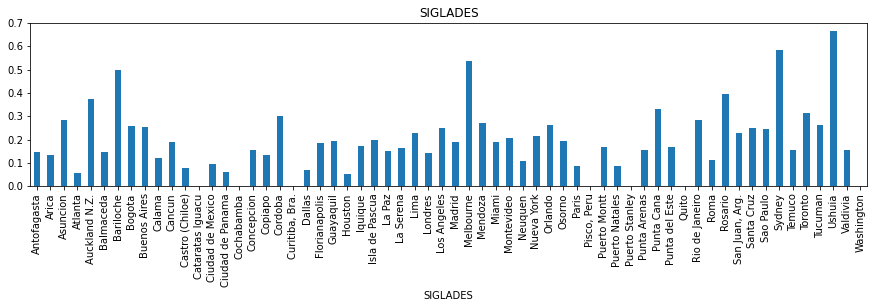

OPERA,Aerolineas Argentinas,Aeromexico,Air Canada,Air France,Alitalia,American Airlines,Austral,Avianca,British Airways,Copa Air,Delta Air,Gol Trans,Grupo LATAM,Iberia,JetSmart SPA,K.L.M.,Lacsa,Latin American Wings,Oceanair Linhas Aereas,Plus Ultra Lineas Aereas,Qantas Airways,Sky Airline,United Airlines
atraso_15,,,,,,,,,,,,,,,,,,,,,,,
0,1481,341,307,328,230,706,59,846,176,1734,337,519,33586,326,899,230,81,993,236,19,82,11758,318
1,468,10,258,30,29,51,15,306,29,116,21,287,7306,36,196,21,11,681,43,30,113,2540,17
Total,1949,351,565,358,259,757,74,1152,205,1850,358,806,40892,362,1095,251,92,1674,279,49,195,14298,335


OPERA,Aerolineas Argentinas,Aeromexico,Air Canada,Air France,Alitalia,American Airlines,Austral,Avianca,British Airways,Copa Air,Delta Air,Gol Trans,Grupo LATAM,Iberia,JetSmart SPA,K.L.M.,Lacsa,Latin American Wings,Oceanair Linhas Aereas,Plus Ultra Lineas Aereas,Qantas Airways,Sky Airline,United Airlines
atraso_15,,,,,,,,,,,,,,,,,,,,,,,
0,0.7599,0.9715,0.5434,0.9162,0.8880,0.9326,0.7973,0.7344,0.8585,0.9373,0.9413,0.6439,0.8213,0.9006,0.8210,0.9163,0.8804,0.5932,0.8459,0.3878,0.4205,0.8224,0.9493
1,0.2401,0.0285,0.4566,0.0838,0.1120,0.0674,0.2027,0.2656,0.1415,0.0627,0.0587,0.3561,0.1787,0.0994,0.1790,0.0837,0.1196,0.4068,0.1541,0.6122,0.5795,0.1776,0.0507


OPERA
Aerolineas Argentinas       7.4283
Aeromexico                  0.0000
Air Canada                 15.0280
Air France                  1.9413
Alitalia                    2.9301
American Airlines           1.3647
Austral                     6.1149
Avianca                     8.3234
British Airways             3.9654
Copa Air                    1.2009
Delta Air                   1.0589
Gol Trans                  11.4984
Grupo LATAM                 5.2712
Iberia                      2.4906
JetSmart SPA                5.2827
K.L.M.                      1.9367
Lacsa                       3.1967
Latin American Wings       13.2790
Oceanair Linhas Aereas      4.4097
Plus Ultra Lineas Aereas   20.4898
Qantas Airways             19.3400
Sky Airline                 5.2354
United Airlines             0.7812
Name: 1, dtype: float64

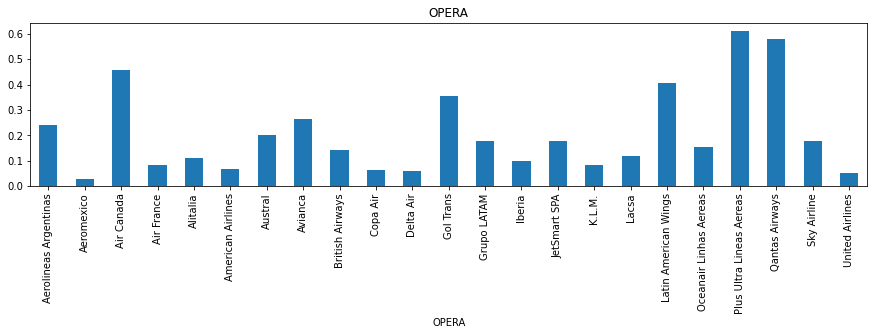

MES,1,2,3,4,5,6,7,8,9,10,11,12
atraso_15,,,,,,,,,,,,
0,5130,4718,4851,4435,4413,4129,4234,4748,4643,4669,4881,4741
1,978,843,631,585,827,852,1758,996,967,1363,1199,1615
Total,6108,5561,5482,5020,5240,4981,5992,5744,5610,6032,6080,6356


MES,1,2,3,4,5,6,7,8,9,10,11,12
atraso_15,,,,,,,,,,,,
0,0.8399,0.8484,0.8849,0.8835,0.8422,0.8290,0.7066,0.8266,0.8276,0.7740,0.8028,0.7459
1,0.1601,0.1516,0.1151,0.1165,0.1578,0.1710,0.2934,0.1734,0.1724,0.2260,0.1972,0.2541


MES
1    0.3911
2    0.3170
3    0.0000
4    0.0124
5    0.3711
6    0.4860
7    1.5489
8    0.5064
9    0.4975
10   0.9631
11   0.7133
12   1.2075
Name: 1, dtype: float64

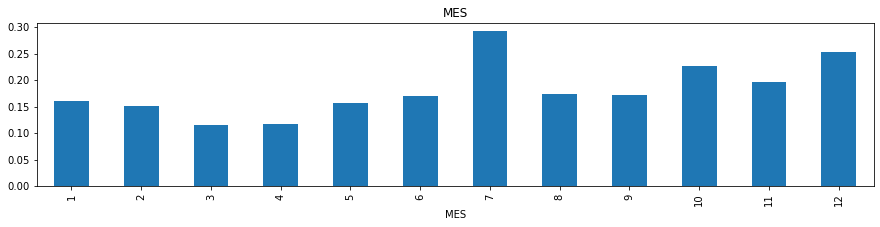

DIANOM,Domingo,Jueves,Lunes,Martes,Miercoles,Sabado,Viernes
atraso_15,,,,,,,
0,8218,8206,8083,8028,8061,6989,8007
1,1578,2045,2048,1634,1661,1363,2285
Total,9796,10251,10131,9662,9722,8352,10292


DIANOM,Domingo,Jueves,Lunes,Martes,Miercoles,Sabado,Viernes
atraso_15,,,,,,,
0,0.8389,0.8005,0.7978,0.8309,0.8292,0.8368,0.7780
1,0.1611,0.1995,0.2022,0.1691,0.1708,0.1632,0.2220


DIANOM
Domingo     0.0000
Jueves      0.2384
Lunes       0.2549
Martes      0.0498
Miercoles   0.0606
Sabado      0.0131
Viernes     0.3783
Name: 1, dtype: float64

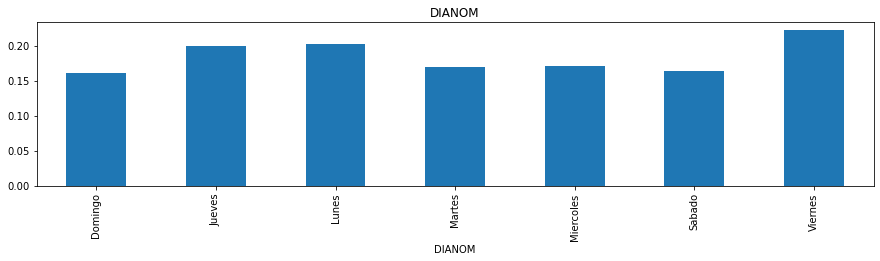

temporada_alta,0,1
atraso_15,,
0,37300,18292
1,8144,4470
Total,45444,22762


temporada_alta,0,1
atraso_15,,
0,0.8208,0.8036
1,0.1792,0.1964


temporada_alta
0   0.0000
1   0.0958
Name: 1, dtype: float64

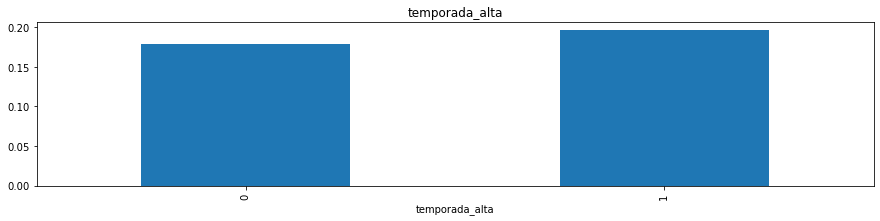

TIPOVUELO,I,N
atraso_15,,
0,24192,31400
1,7048,5566
Total,31240,36966


TIPOVUELO,I,N
atraso_15,,
0,0.7744,0.8494
1,0.2256,0.1506


TIPOVUELO
I   0.4984
N   0.0000
Name: 1, dtype: float64

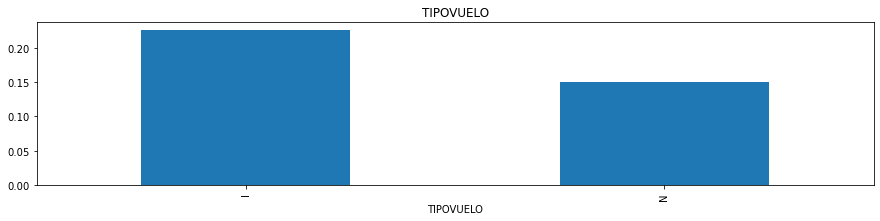

atraso_15,0,1
atraso_15,,
0,55592.0000,nan
1,nan,12614.0000
Total,55592.0000,12614.0000


atraso_15,0,1
atraso_15,,
0,nan,nan
1,nan,nan


atraso_15
0   nan
1   nan
Name: 1, dtype: float64

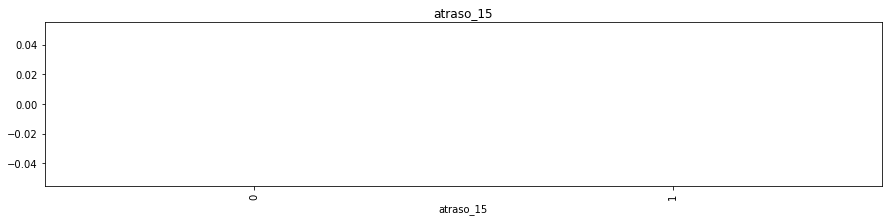

If_Des_diff,False,True
atraso_15,,
0,55572,20
1,12606,8
Total,68178,28


If_Des_diff,False,True
atraso_15,,
0,0.8151,0.7143
1,0.1849,0.2857


If_Des_diff
False   0.0000
True    0.5453
Name: 1, dtype: float64

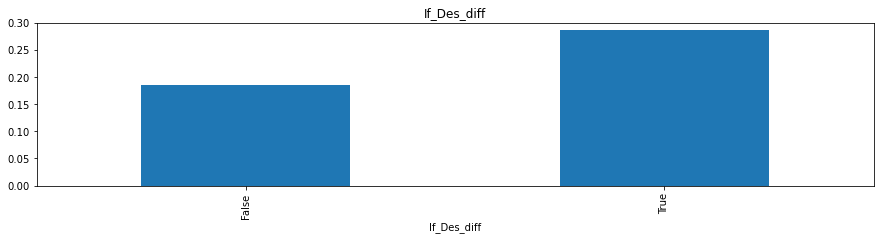

If_Emp_diff,False,True
atraso_15,,
0,40284,15308
1,9253,3361
Total,49537,18669


If_Emp_diff,False,True
atraso_15,,
0,0.8132,0.8200
1,0.1868,0.1800


If_Emp_diff
False   0.0375
True    0.0000
Name: 1, dtype: float64

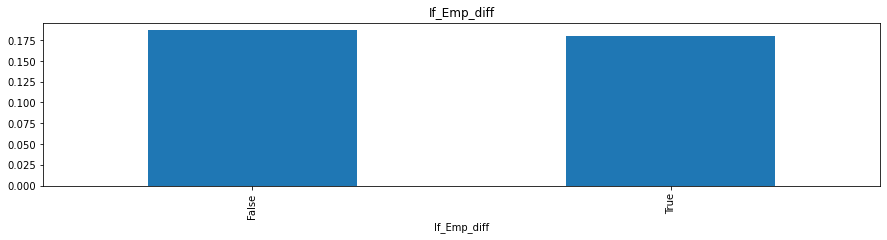

['dif_min']

In [43]:
cols_sin_plot = []

for i in cols_analysis:
    if df[i].drop_duplicates().shape[0] < 100:
        categ_plots_grouped(df.groupby("atraso_15"), i)
    else:
        cols_sin_plot.append(i)
        
cols_sin_plot

#### Síntesis de gráficos

- `SIGLADES`: Vemos que la distribución de los vuelos atrasados varía según el destino, probablemente implique que la asignación de un avión a una determinada puerta de embarque/desembarque no dependa del destino en específico de dicho vuelo.
- `OPERA`: Se puede apreciar una decente concentración de los atrasos en algunas operadoras, esta variable probablemente vaya a salir significativa a la hora de modelar.
- `MES` Los meses de Julio y Diciembre concentran la cantidad de atrasos. Recordemos que los meses 1,7, y 12 eran los meses con más vuelos en el año 2017. Aquí el mes 1, a pesar de tener tantos vuelos como los meses 7 y 12 (según el gráfico de análisis univariado), muestra una tasa de atrasos bastante menor. Si asumimos que la capacidad de gestión de vuelos por mes es constante, podemos descartar que las altas tasas de atraso de los meses 7 y 12 se deben a falta de capacidad y, en consecuencia, habría que evaluar qué se hace bien en el aeropuerto en el mes 1 que no se hace bien en los meses 7 y 12.
- `DIANOM`: Los atrasos no parecen ser uniformes como lo parecían ser en el análisis univariado de esta misma variable. El día viernes alcanza un 37,8% más de atrasos que el día domingo (ver la serie que está justo por encima del gráfico)
- `temporada_alta`: Tenemos que en temporada alta ocurren casi un 10% más de atrasos. Lo cual no suele parece ser significativo si la comparamos con las otras tasas (ej: 37,8% más de atrasos un viernes que un domingo)
- `TIPOVUELO`: Existen un 50% más de atrasos en vuelos internacionales que en vuelos nacionales. Probablemente esta variable también vaya a ser significativa
- `If_Des_diff`: Existe un 54,5% más de atrasos en los vuelos cuyo código de destino se cambió al cual estaba inicialmente planificado.
- `If_Emp_diff`: Esta variable no parece ser relevante.

## Metodología de modelamiento

Para predecir de forma adecuada, en términos del negocio, la probabilidad de que un vuelo se atrase en el futuro hay que considerar la **temporalidad** bajo la cual se predice, y la temporalidad depende del ciclo del problema. Por lo que la pregunta sería, **¿cuál es el ciclo del problema?** Podríamos decir que es diaria (o incluso en horas), dado que (basándome en mi experiencia cuando he viajado) las puertas de embarque/desembarque de los aviones no están definidas hasta un par de horas antes del vuelo. Sin embargo, asumamos que podemos crear un modelo perfecto, y al reportarle al área de operaciones qué vuelos se atrasarán lo importante es saber ¿porqué se atrasarán?. Dado que así ellos podrán tomar iniciativas para evitar que dichos vuelos no se atrasen. Por otra parte, (asumo que) el área de operaciones también necesitará un tiempo de planificación y evaluación de iniciativas desde que toman el input del modelo predictivo sobre qué vuelos se atrasarán.

Dada la lógica de negocios anterior, al evaluar un modelo con el estándar random train-test-split 70%-30% implica tener en el dataset train observaciones fuera de la temporalidad de tiempo correspondiente, incurriendo en *data leakage*. Por ejemplo, el dataset que estamos trabajando tiene datos de todo el año 2017, y al hacer train-test split 70%-30% nos quedarán 70% de las observaciones de todos los meses en el dataset train, y el 30% de las observaciones de todos los meses en el dataset test, cuando el dataset test debería ser el dataset representativo que buscamos representar en la realidad. En otras palabras, si queremos predecir los atrasos para Enero 2018, las observaciones del dataset test no representa el dataset que tendríamos para Enero 2018, dado que el test contiene observaciones pertenecientes a todos los meses del año.

En los gráficos de análisis bivariado, específicamente el de la variable `MES` la distribución mensual cambia en relación a las personas que compraron vs al total de su propio mes. 

Por lo tanto, haremos tres métodos:

- **Método (1)**: Modelaremos train-test split 70%-30%, o sea, tanto el dataset como train y test tendrán observaciones de todos los meses (*data leakage*)
- **Método (2)**: Modelaremos con datos de Enero a Noviembre inclusive como train, dejando Diciembre 2017 como test
- **Método (3)**: Modelaremos con datos de Enero a mediados de Diciembre inclusive como train, dejando la penúltima semana como test, y la última como hold-out

### Definición de métrica de evaluación

La métrica a utilizar será la curva de ROC/AUC debido a que es una buena medida para datasets con target desbalanceados, que en este desafío el desbalance está entre el 10% y el 25% mensual, como se puede ver más abajo.

In [44]:
df["Ano_Mes"] = df["Fecha-I"].dt.strftime("%Y-%m")
pd.concat([df.groupby("Ano_Mes")["atraso_15"].value_counts().rename("count"),
          df.groupby("Ano_Mes")["atraso_15"].value_counts(normalize=True).rename("pct")],
          axis=1)

count    pct
Ano_Mes atraso_15              
2017-01 0           5129 0.8397
        1            979 0.1603
2017-02 0           4718 0.8484
        1            843 0.1516
2017-03 0           4851 0.8852
        1            629 0.1148
2017-04 0           4435 0.8833
        1            586 0.1167
2017-05 0           4413 0.8423
        1            826 0.1577
2017-06 0           4130 0.8290
        1            852 0.1710
2017-07 0           4233 0.7066
        1           1758 0.2934
2017-08 0           4748 0.8266
        1            996 0.1734
2017-09 0           4643 0.8276
        1            967 0.1724
2017-10 0           4669 0.7740
        1           1363 0.2260
2017-11 0           4881 0.8027
        1           1200 0.1973
2017-12 0           4742 0.7459
        1           1615 0.2541

### Tratamiento de variables cíclicas

Antes de modelar, tenemos que hacer un tratamiento a las variables cíclicas. ¿La razón? Porque cuando son las 23:00 hrs, falta sólo una hora para medianoche (00:00 hrs), pero el modelo la interpreta como una diferencia de 23 horas. Este tratamiento lo haremos para el mes, día del mes, día de la semana, y hora. La fórmula para la transformación es la siguiente:

$x_{sin} = sin\left(\frac{2*\pi*x}{max(x)}\right)$

$x_{cos} = cos\left(\frac{2*\pi*x}{max(x)}\right)$

In [45]:
df['MES_sin'] = np.sin(2 * np.pi * (df["Fecha-I"].dt.month-1)/11)
df['MES_cos'] = np.cos(2 * np.pi * (df["Fecha-I"].dt.month-1)/11)

df['DIA_sin'] = np.sin(2 * np.pi * (df["Fecha-I"].dt.day-1)/30)
df['DIA_cos'] = np.cos(2 * np.pi * (df["Fecha-I"].dt.day-1)/30)

df['DIASEM_sin'] = np.sin(2 * np.pi * (df["Fecha-I"].dt.dayofweek)/6)
df['DIASEM_cos'] = np.cos(2 * np.pi * (df["Fecha-I"].dt.dayofweek)/6)

df['Hr_sin'] = np.sin(2 * np.pi * df["Fecha-I"].dt.hour/23.0)
df['Hr_cos'] = np.cos(2 * np.pi * df["Fecha-I"].dt.hour/23.0)

### Dataset modelamiento

In [46]:
df.columns

Index(['Fecha-I', 'Vlo-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O', 'Des-O',
       'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO', 'OPERA',
       'SIGLADES', 'dif_min', 'atraso_15', 'Mes-Dia', 'temporada_alta',
       'periodo_dia', 'If_Des_diff', 'If_Emp_diff', 'Ano_Mes', 'MES_sin',
       'MES_cos', 'DIA_sin', 'DIA_cos', 'DIASEM_sin', 'DIASEM_cos', 'Hr_sin',
       'Hr_cos'],
      dtype='object')

In [47]:
cols_to_drop = ["Vlo-I", "Des-I", "Emp-I", "Fecha-O", "Vlo-O", "Des-O", "Emp-O", "DIA","MES","AÑO", "DIANOM",
                "Mes-Dia", "dif_min", "AÑO", "Ano_Mes"]
df_ml = df.drop(cols_to_drop, axis=1)
df_ml[["If_Des_diff", "If_Emp_diff"]] = df_ml[["If_Des_diff", "If_Emp_diff"]].replace({True:1, False:0})

In [48]:
# Tratamiento de variables para que PyCaret los deduzca bien
for i in df_ml.columns:
    if df_ml[i].drop_duplicates().shape[0] == 2:
        df_ml[i] = df_ml[i].astype(str)
df_ml.dtypes

Fecha-I           datetime64[ns]
TIPOVUELO                 object
OPERA                     object
SIGLADES                  object
atraso_15                 object
temporada_alta            object
periodo_dia               object
If_Des_diff               object
If_Emp_diff               object
MES_sin                  float64
MES_cos                  float64
DIA_sin                  float64
DIA_cos                  float64
DIASEM_sin               float64
DIASEM_cos               float64
Hr_sin                   float64
Hr_cos                   float64
dtype: object

In [49]:
num_feat = df_ml.select_dtypes(include="float64").columns
cat_feat = df_ml.select_dtypes(include="object").columns.drop("atraso_15")
time_feat = df_ml.select_dtypes(include="datetime").columns

In [50]:
# No hay necesidad de separar para metodo 1

# Dataset metodo 2
met_2_train = df_ml[df_ml["Fecha-I"].dt.month != 12] 
met_2_test = df_ml[df_ml["Fecha-I"].dt.month == 12]

# Dataset metodo 3
met_3_train = df_ml[df_ml["Fecha-I"].dt.isocalendar()["week"] <= 50] 
met_3_test = df_ml[df_ml["Fecha-I"].dt.isocalendar()["week"] == 51] # penúltima semana
met_3_hold_out = df_ml[df_ml["Fecha-I"].dt.isocalendar()["week"] == 52] # última semana

## Entrenamiento y evaluación de modelos

PyCaret es un paquete AutoML fascinante. Ahorra un montón de líneas de código en unas cuantas. En una próxima actualización de este notebook mostraré que con PyCaret se pueden personalizar y mezclar modelos como uno quiera, pero por ahora mantendremos las cosas simples.

In [51]:
from pycaret.classification import *

#### Método 1

In [52]:
 # Por default hace train-test-split 70%-30%, stratifiedkfold, y clasifica los object a categorías (con mi confirmación)
grid_met_1 = setup(data=df_ml, 
                   target="atraso_15", 
                   session_id = 0,
                   ignore_features = ["Fecha-I"],
                   fold=5,
                   data_split_stratify=True, # train-test-split estratificado según la variable dependiente
                   feature_selection=True, # selección de variables según Random Forest, Adaboost and Linear correlation con la variable dependiente
                   silent=True, # Elimino la confirmación de clasificar los object a categorías (dado que no es necesaria porque deduce el dtype bien)
                   ignore_low_variance=True)

# ignore_low_variance=True implica que las variables categóricas se eliminan si y sólo si se cumplen ambas condiciones:
# (1) Cantidad de valores únicos en una variable / n_observaciones < 10%
# (2) Cantidad del valor más común / cantidad del segundo valor más común > 20

best_met_1 = compare_models(sort = "AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8269,0.7383,0.1444,0.6423,0.2357,0.1801,0.2453,15.7800
lightgbm,Light Gradient Boosting Machine,0.8253,0.7310,0.1103,0.6684,0.1893,0.1445,0.2209,0.4740
xgboost,Extreme Gradient Boosting,0.8250,0.7301,0.1544,0.6057,0.2459,0.1847,0.2409,3.3540
rf,Random Forest Classifier,0.8148,0.7054,0.1536,0.4981,0.2347,0.1617,0.1983,2.0980
gbc,Gradient Boosting Classifier,0.8188,0.6890,0.0378,0.6844,0.0717,0.0533,0.1307,2.4240
et,Extra Trees Classifier,0.8026,0.6819,0.1805,0.4217,0.2528,0.1596,0.1788,2.8940
ada,Ada Boost Classifier,0.8165,0.6719,0.0361,0.5598,0.0679,0.0466,0.1061,0.6980
lr,Logistic Regression,0.8172,0.6578,0.0384,0.5894,0.0721,0.0506,0.1150,2.1180
lda,Linear Discriminant Analysis,0.8157,0.6575,0.0701,0.5124,0.1233,0.0825,0.1359,0.3980
knn,K Neighbors Classifier,0.8005,0.6406,0.1761,0.4090,0.2462,0.1517,0.1697,5.5220


In [53]:
predict_model(best_met_1);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8275,0.7459,0.1575,0.6361,0.2525,0.1933,0.2546


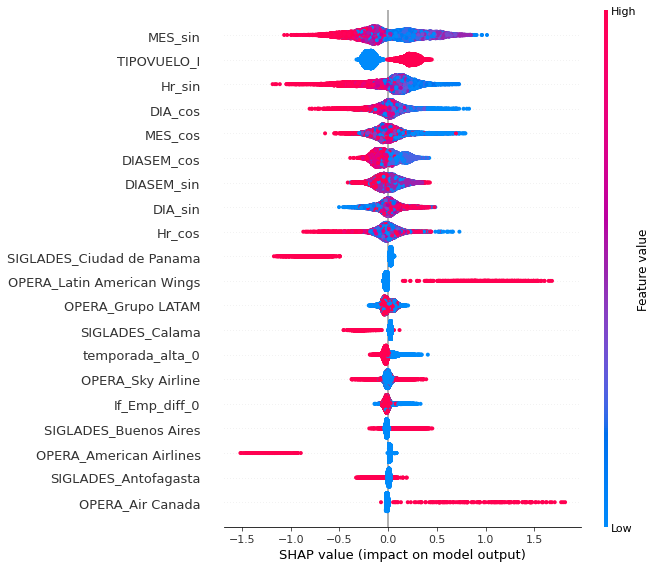

In [54]:
interpret_model(best_met_1)

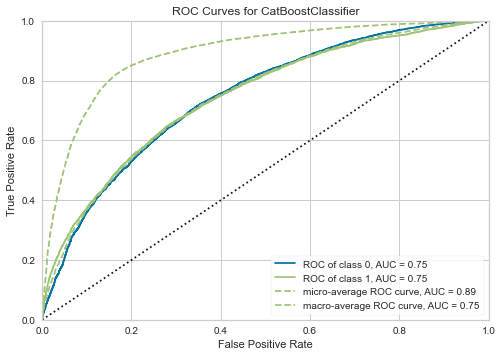

In [55]:
plot_model(best_met_1)

#### Método 2

In [56]:
grid_met_2 = setup(data = met_2_train, 
                   target="atraso_15", 
                   test_data= met_2_test,
                   session_id = 0,
                   ignore_features = ["Fecha-I"],
                   fold=5,
                   feature_selection=True,
                   silent=True,
                   ignore_low_variance=True) 

best_met_2 = compare_models(sort = "AUC", n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8170,0.6190,0.0444,0.3408,0.0680,0.0395,0.0661,1.6440
lda,Linear Discriminant Analysis,0.8122,0.6185,0.0734,0.4114,0.1081,0.0611,0.0923,0.5640
nb,Naive Bayes,0.2772,0.6162,0.9233,0.1882,0.3125,0.0243,0.0698,0.1540
knn,K Neighbors Classifier,0.7586,0.5320,0.1519,0.2404,0.1741,0.0474,0.0521,9.2900
qda,Quadratic Discriminant Analysis,0.7342,0.4829,0.0928,0.3360,0.0879,-0.0297,-0.0245,0.4100
ada,Ada Boost Classifier,0.6545,0.4446,0.1850,0.1974,0.1305,-0.0415,-0.0409,0.9520
catboost,CatBoost Classifier,0.3944,0.4289,0.3733,0.1834,0.1514,-0.1108,-0.1579,18.3240
gbc,Gradient Boosting Classifier,0.4572,0.4267,0.3413,0.1966,0.1435,-0.1028,-0.1118,3.0020
xgboost,Extreme Gradient Boosting,0.4394,0.4255,0.3352,0.1595,0.1369,-0.1150,-0.1401,4.4780
lightgbm,Light Gradient Boosting Machine,0.4548,0.4132,0.3253,0.1808,0.1382,-0.1102,-0.1263,0.5020


In [57]:
# Mejor modelo
best_met_2[1]

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [58]:
predict_model(best_met_2[1])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.7505,0.6551,0.0365,0.6629,0.0692,0.0439,0.1119


,OPERA_Avianca,SIGLADES_Miami,SIGLADES_Castro (Chiloe),SIGLADES_Tucuman,SIGLADES_Punta Cana,periodo_dia_Noche,SIGLADES_Lima,SIGLADES_San Juan Arg.,SIGLADES_Ciudad de Mexico,MES_cos,...,OPERA_Lacsa,SIGLADES_Puerto Stanley,SIGLADES_Neuquen,SIGLADES_Rio de Janeiro,SIGLADES_Balmaceda,SIGLADES_Concepcion,SIGLADES_Osorno,atraso_15,Label,Score
0,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0.9294
1,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0.9376
2,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0.9389
3,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.9395
4,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0.9344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6352,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.7930
6353,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.8312
6354,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.8282
6355,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0.8055


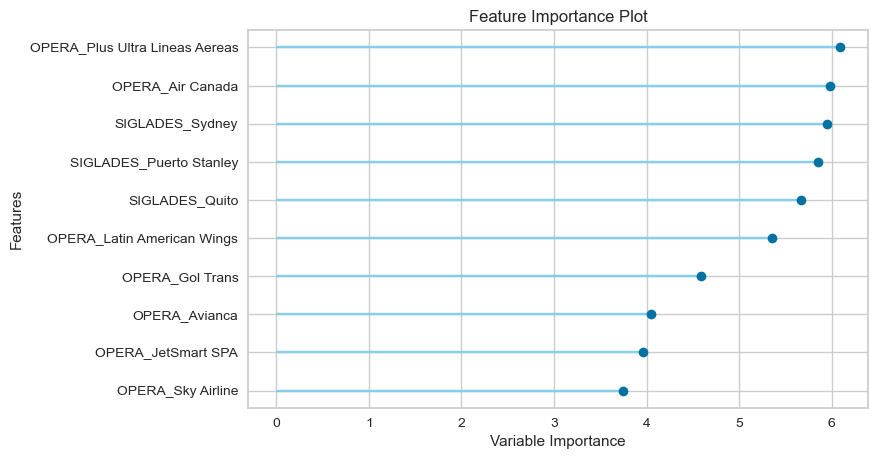

In [59]:
plot_model(best_met_2[1], plot = 'feature') # Linear Discriminant Analysis

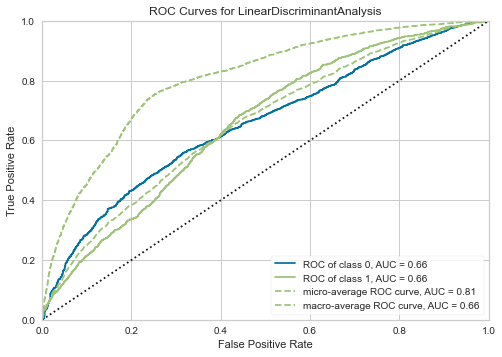

In [60]:
plot_model(best_met_2[1], plot="auc")

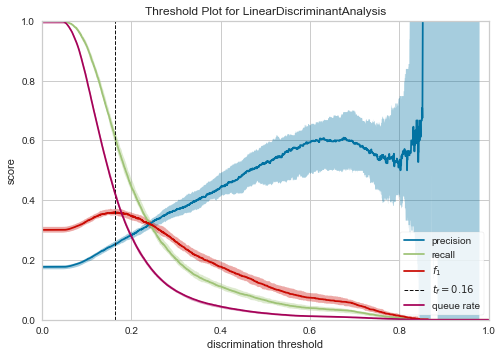

In [61]:
plot_model(best_met_2[1], plot="threshold")

#### Método 3: penúltima semana

In [62]:
grid_met_3 = setup(data = met_3_train, 
                   target="atraso_15", 
                   test_data= met_3_test,
                   session_id = 0,
                   ignore_features = ["Fecha-I"],
                   fold=5,
                   feature_selection=True,
                   silent=True,
                   ignore_low_variance=True)

best_met_3 = compare_models(sort = "AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5368,0.6118,0.6145,0.2286,0.3226,0.0864,0.1116,0.1500
lr,Logistic Regression,0.8143,0.6087,0.0430,0.5559,0.0711,0.0407,0.0813,1.5660
lda,Linear Discriminant Analysis,0.8107,0.6080,0.0693,0.4466,0.1115,0.0631,0.1020,0.5680
knn,K Neighbors Classifier,0.7395,0.5140,0.1615,0.2143,0.1753,0.0310,0.0326,10.5080
qda,Quadratic Discriminant Analysis,0.7800,0.5036,0.0700,0.2344,0.0737,0.0099,0.0173,0.4720
ada,Ada Boost Classifier,0.6606,0.4508,0.1966,0.2506,0.1124,-0.0209,-0.0164,0.9840
gbc,Gradient Boosting Classifier,0.5639,0.4236,0.2717,0.1989,0.1352,-0.0764,-0.0791,3.2340
dt,Decision Tree Classifier,0.4369,0.4192,0.3916,0.1310,0.1856,-0.0948,-0.1629,0.2280
lightgbm,Light Gradient Boosting Machine,0.4743,0.4162,0.3463,0.1687,0.1557,-0.0893,-0.1420,0.5660
xgboost,Extreme Gradient Boosting,0.4876,0.4080,0.3200,0.1536,0.1585,-0.0907,-0.1462,4.9940


In [63]:
predict_model(best_met_3);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.6120,0.5970,0.4583,0.4434,0.4507,0.1509,0.1510


#### Método 3: última semana

In [64]:
grid_met_3 = setup(data = met_3_train, 
                   target="atraso_15", 
                   test_data= met_3_hold_out,
                   session_id = 0,
                   ignore_features = ["Fecha-I"],
                   fold=5,
                   silent=True,
                   ignore_low_variance=True)

best_met_3 = compare_models(sort = "AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5368,0.6118,0.6145,0.2286,0.3226,0.0864,0.1116,0.1440
lr,Logistic Regression,0.8143,0.6087,0.0431,0.5571,0.0712,0.0408,0.0817,1.6600
lda,Linear Discriminant Analysis,0.8107,0.6080,0.0693,0.4466,0.1115,0.0631,0.1020,0.5800
qda,Quadratic Discriminant Analysis,0.7023,0.5145,0.2198,0.1975,0.1720,0.0211,0.0264,0.4480
knn,K Neighbors Classifier,0.7396,0.5139,0.1615,0.2139,0.1751,0.0309,0.0325,10.0800
ada,Ada Boost Classifier,0.6606,0.4508,0.1966,0.2506,0.1124,-0.0209,-0.0164,0.9920
gbc,Gradient Boosting Classifier,0.5639,0.4237,0.2717,0.1989,0.1352,-0.0764,-0.0791,3.2640
dt,Decision Tree Classifier,0.4371,0.4172,0.3865,0.1291,0.1827,-0.0977,-0.1661,0.1960
lightgbm,Light Gradient Boosting Machine,0.4730,0.4166,0.3475,0.1694,0.1561,-0.0893,-0.1422,0.4720
xgboost,Extreme Gradient Boosting,0.4915,0.4096,0.3108,0.1508,0.1568,-0.0929,-0.1482,4.9560


In [65]:
predict_model(best_met_3);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.6308,0.6229,0.5154,0.2546,0.3409,0.1236,0.1384


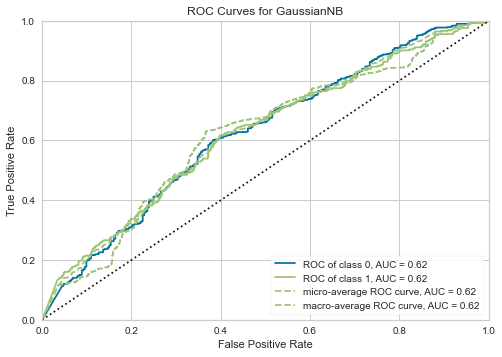

In [66]:
plot_model(best_met_3)

### Síntesis, comparación de los métodos, pasos a seguir e ideas finales

Vemos que el **método 1** tuvo el mejor desempeño con **AUC de 0.7464** en el dataset test bajo **CatBoostClassifier**. Sin embargo, este método no es fiable. ¿Por qué? Porque estamos incurriendo en data leakage al mezclar todos los meses en train y test, debido que a la hora de predecir tendremos que hacerlo en un mes o semana completa y bajo el caso que debiésemos predecir los atrasos para Enero 2018, el dataset test no representa las características de predecir Enero 2018 porque el dataset test tiene observaciones de todos los meses. Ahora, en qué caso este método sería fiable? En el caso que las observaciones sean **independientes** en relación al tiempo. Y para este caso (según el análisis bivariado que hicimos) no son independientes. 

Si bien en el **método 2** la regresión logística tuvo el mejor **AUC (0.6190)**, escogería el **Linear Discriminant Analysis (LDA)** con AUC de 0.6185 como mejor modelo. ¿Por qué? Porque LDA tuvo una menor performance poco significativa en términos de AUC (menos de 1%) y tuvo bastante mejor performance en otras méticas como Recall y Precision cuyas diferencias son bastante más significativas que el 1% de diferencia en AUC.

El **método 3** es lo mismo que el método 2 pero asumiendo que el ciclo es semanal. El mejor desempeño lo tuvo el **Naive Bayes** con **AUC 0.6118** (y varias otras métricas también). Es interesante que tanto el método 2 como el método 3 tuvieron desempeños parecidos en términos de AUC siendo que son ciclos diferentes. Tal vez sería distinto si probáramos semanas en meses diferentes (método 3 toma dos semanas de diciembre y método 2 toma el mes de diciembre)

#### Pasos a seguir e ideas finales

- (1) **Definición del ciclo para el negocio**: ¿Se predecirá de forma semanal, mensual, o anual? Así podemos definir un ciclo de tiempo para predecir y ajustar las evaluaciones a dicho ciclo. Esto dependerá del ciclo que se piense utilizar el modelo, lo que dependerá mayormente del ciclo de acción del área de operaciones (quienes recibirían este output del modelo)
- (2) **Conseguir la data de años anteriores**. Dado que los comportamientos de Navidad por ejemplo, podrían ser comparables con otras fechas de navidad. Podría detectarse fechas específicas de alta tasa de atrasos que estén ocurriendo específicamente en dichas fechas anuales, y para evaluar eso es buena referencia el comportamiento de la misma fecha en años pasados.
- (3) **Tuning de hiperparámetros**: Ya definido el ciclo, podemos hacer tuning de hyperparámetros para el modelo con la temporalidad correspondiente.
- (4) **Evaluación de desempeño por deciles**: Al dividir las probabilidades en deciles, podemos evaluar cómo se ajusta el modelo a la realidad por decil (los deciles con probabilidades más altas deberían tener un mejor desempeño que los deciles con probabilidades más bajas) y podrían construirse modelos de optimizacíon que se integren al negocio al tener la probabilidad. Un ejemplo es el PPL explicado a continuación.
- (5) **Problema de Programación Lineal (PPL)**: Sería interesante incluir el costo de las multas por unidad de tiempo al modelo y hacer un problema de programación lineal para optimizar la gestión de operaciones en términos de impacto al negocio. Por ejemplo, si se cobrara $X$ UFs por cada 20 minutos de atraso o fracción con una tolerancia inicial de 10 minutos de atraso a 0 UF, y $X$ depende del tipo de vuelo (internacional o nacional, siendo internacional una multa más alta), de la hora del día (la multa es más alta en las horas pic de vuelo, porque si un vuelo se atrasa puede desencadenar más atrasos, especialmente en horas pic de vuelos), entre otras. Con este costo y la probabilidad de atraso, si el área de operaciones no tiene capacidad para tratar todos los vuelos con altas probabilidades en un intervalo de tiempo, se pueden priorizar los atrasos con altas probabilidades de atraso y con costo altas. O aún más, podría integrarse la asignación del personal de operaciones a determinados horarios del día de tal forma de minimizar el costo probable de los atrasos (costo multas * probabilidad de modelo), de acuerdo a los horarios de trabajo, cantidad de operadores disponibles, etc.